In [4]:
from bitcoin_listener import OrderBook
import bitcoin_listener as btcl

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# from list of dates read file
# read ask-bid-vol
# read ask-bid-orderbook til n/vol/...
# read ask-bid and estimate params
# save summary on database

In [10]:
#technical analysis

In [137]:
from bitcoin_listener import OrderBook
import os
import gzip
import numpy as np
import datetime as dt
import bitcoin_listener as btcl
source_orderbook = btcl.config['DEFAULT']['source_orderbook']


class Reader:
    
    def __init__(self, exchange):
        self.exchange = exchange
        self.dates = self.read_dates()

    def read_dates(self):
            
        if self.exchange not in OrderBook.EXCHANGES.keys():
            return []
        
        p = os.path.join(source_orderbook, self.exchange)
        
        return sorted([
            ".".join(f.split(".")[:-1]) for f in os.listdir(p)
            if os.path.isfile(os.path.join(p, f))
        ])

    def read_file(self, date):
        if self.exchange not in OrderBook.EXCHANGES.keys():
            return ""
        if date not in self.dates:
            return ""

        p = os.path.join(source_orderbook, self.exchange, "{}.gz".format(date))

        file_text = ""
        with gzip.open(p,'r') as gf: 
            file_text = gf.read().decode('utf-8')
        return file_text

    def get_orderbook(self, date, lim_orderbook=None):
        if self.exchange not in OrderBook.EXCHANGES.keys():
            return np.array([])
        if date not in self.read_dates():
            return np.array([])
        if not lim_orderbook:
            return np.array([])

        adj_price = OrderBook.EXCHANGES[self.exchange]['best_shift']['price']
        adj_amount = OrderBook.EXCHANGES[self.exchange]['best_shift']['amount']

        text = self.read_file(date)

        lines = [l for l in text.split('\n') if l]
        s = len(lines)

        data = np.ndarray(s, dtype=np.dtype([
                ('epoch', dt.datetime), 
                ('ask', np.dtype([('price', float),('qtd', 'uint')])), 
                ('bid', np.dtype([('price', float),('qtd', 'uint')])), 
                ('orderbook', np.dtype([('ask', np.ndarray),('bid', np.ndarray)]))
            ]))

        for i in range(s):

            d = lines[i].split('|')

            data[i]['epoch'] = dt.datetime.fromtimestamp(int(d[0]))

            qtd_askbid = [float(v) for v in d[1].split(' ')]
            data[i]['ask']['qtd'] = qtd_askbid[0]
            data[i]['bid']['qtd'] = qtd_askbid[1]

            list_asks = d[2].split(' ')[:lim_orderbook]
            oask = np.ndarray(len(list_asks), dtype=[('price', float), ('amount', float)])
            oask['price'] = np.cumsum([float(p.split(',')[0])/10**adj_price for p in list_asks])
            oask['amount'] = [float(p.split(',')[1])/10**adj_amount for p in list_asks]
            data[i]['ask']['price'] = oask['price'][0]
            data[i]['orderbook']['ask'] = oask

            list_bids = d[3].split(' ')[:lim_orderbook]
            obid = np.ndarray(len(list_bids), dtype=[('price', float), ('amount', float)])
            obid['price'] = np.cumsum([float(p.split(',')[0])/10**adj_price for p in list_bids])
            obid['amount'] = [float(p.split(',')[1])/10**adj_amount for p in list_bids]
            data[i]['bid']['price'] = obid['price'][0]
            data[i]['orderbook']['bid'] = obid

        return data
    
    def get(self, list_dates, lim_orderbook=1):
        list_data = []
        for date in list_dates:
            d = self.get_orderbook(date, lim_orderbook)
            if d.size>0:
                list_data.append(d)
        return np.concatenate(list_data) if len(list_data)>0 else np.array([])

In [138]:
r = Reader('bitstamp')
x = r.get(['2018-05-25','2018-05-26'], 1000)

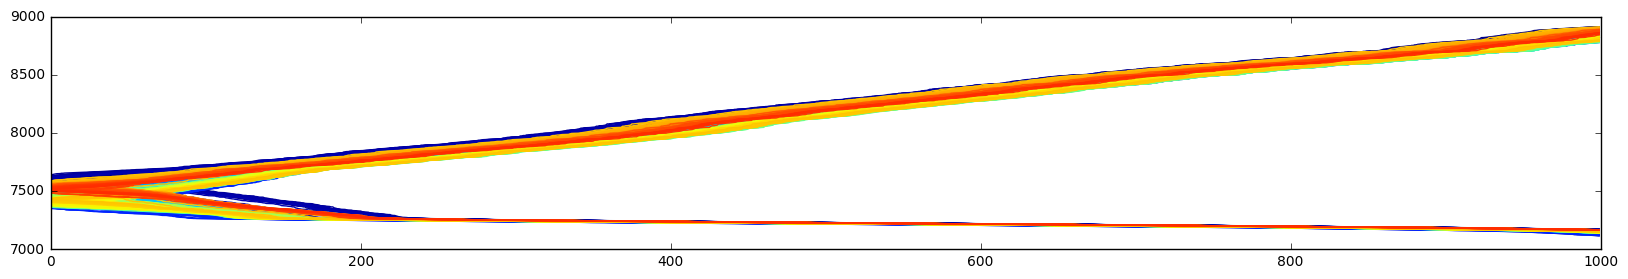

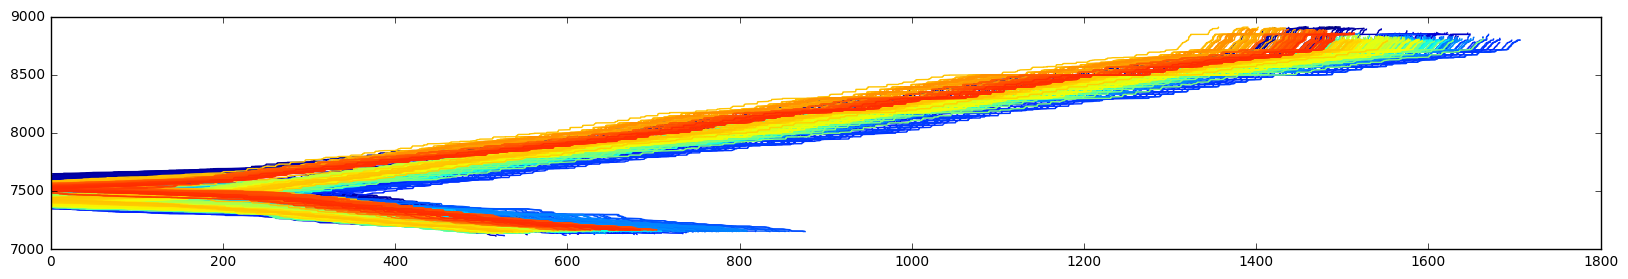

In [139]:
N = 100
X = x.size

hsv = plt.get_cmap('jet')
colors = hsv(np.linspace(0, 1.0, X))

plt.figure(figsize=(20,3))
for i in range(X-N):
    plt.plot(x[i+N]['orderbook']['ask']['price'], color=colors[i])
    plt.plot(x[i+N]['orderbook']['bid']['price'], color=colors[i])
plt.show()
plt.figure(figsize=(20,3))
for i in range(X-N):
    plt.plot(np.cumsum(x[i+N]['orderbook']['ask']['amount']),x[i+N]['orderbook']['ask']['price'], color=colors[i])
    plt.plot(np.cumsum(x[i+N]['orderbook']['bid']['amount']),x[i+N]['orderbook']['bid']['price'], color=colors[i])
plt.show()

In [140]:
from scipy.optimize import curve_fit

i=-1

def price(x, a, b, c, d, e):
    return b*x**3 + c*x**2 + d*x
def amount(x, a, b, c, d, e):
    return b*x**3 + c*x**2 + d*x

K=5000

N = len(x[i]['orderbook']['ask']['amount'][:K])
xdata = np.linspace(0,N,N)

yaskamount = np.cumsum(x[i]['orderbook']['ask']['amount'][:K])
yask0 = x[i]['orderbook']['ask']['price'][0]
yaskprice = x[i]['orderbook']['ask']['price'][:K]-yask0


ybidamount = np.cumsum(x[i]['orderbook']['bid']['amount'][:K])
ybid0 = x[i]['orderbook']['bid']['price'][0]
ybidprice = x[i]['orderbook']['bid']['price'][:K]-ybid0

argsaskamount, _ = curve_fit(amount, xdata, yaskamount)
argsaskprice, _ = curve_fit(price, xdata, yaskprice, sigma=1+xdata, absolute_sigma=True)

argsbidamount, _ = curve_fit(amount, xdata, ybidamount)
argsbidprice, _ = curve_fit(price, xdata, ybidprice, sigma=1+xdata, absolute_sigma=True)

argsaskamount, argsaskprice, argsbidamount, argsbidprice

/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([ 1.00000000e+00, -6.58958668e-08, -4.96075848e-04,  2.09106641e+00,
         1.00000000e+00]),
 array([ 1.00000000e+00, -7.17466586e-07,  9.98854800e-04,  1.01758547e+00,
         1.00000000e+00]),
 array([ 1.00000000e+00,  2.79385102e-06, -5.06033258e-03,  2.97987071e+00,
         1.00000000e+00]),
 array([ 1.00000000e+00,  3.67262414e-08,  6.99252080e-04, -9.83012310e-01,
         1.00000000e+00]))

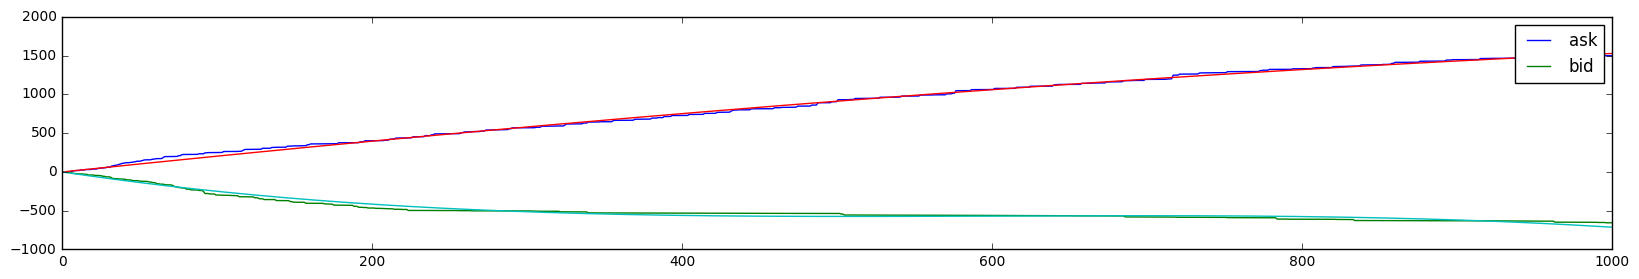

In [141]:
plt.figure(figsize=(20,3))
plt.plot(xdata, yaskamount, label='ask')
plt.plot(xdata, -ybidamount, label='bid')

plt.plot(xdata, amount(xdata, *argsaskamount))
plt.plot(xdata, -amount(xdata, *argsbidamount))
plt.legend()
plt.show()

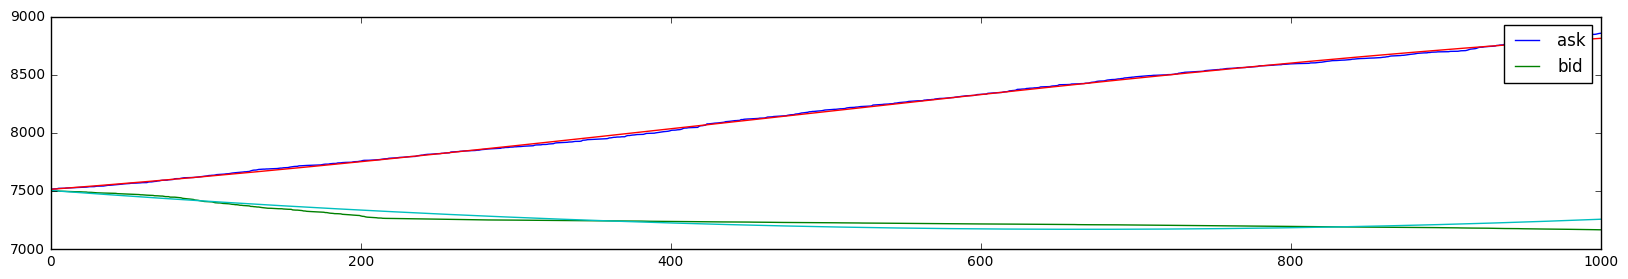

In [142]:
plt.figure(figsize=(20,3))
plt.plot(xdata, yask0+yaskprice, label='ask')
plt.plot(xdata, ybid0+ybidprice, label='bid')

plt.plot(xdata, yask0+price(xdata, *argsaskprice))
plt.plot(xdata, ybid0+price(xdata, *argsbidprice))
plt.legend()
plt.show()

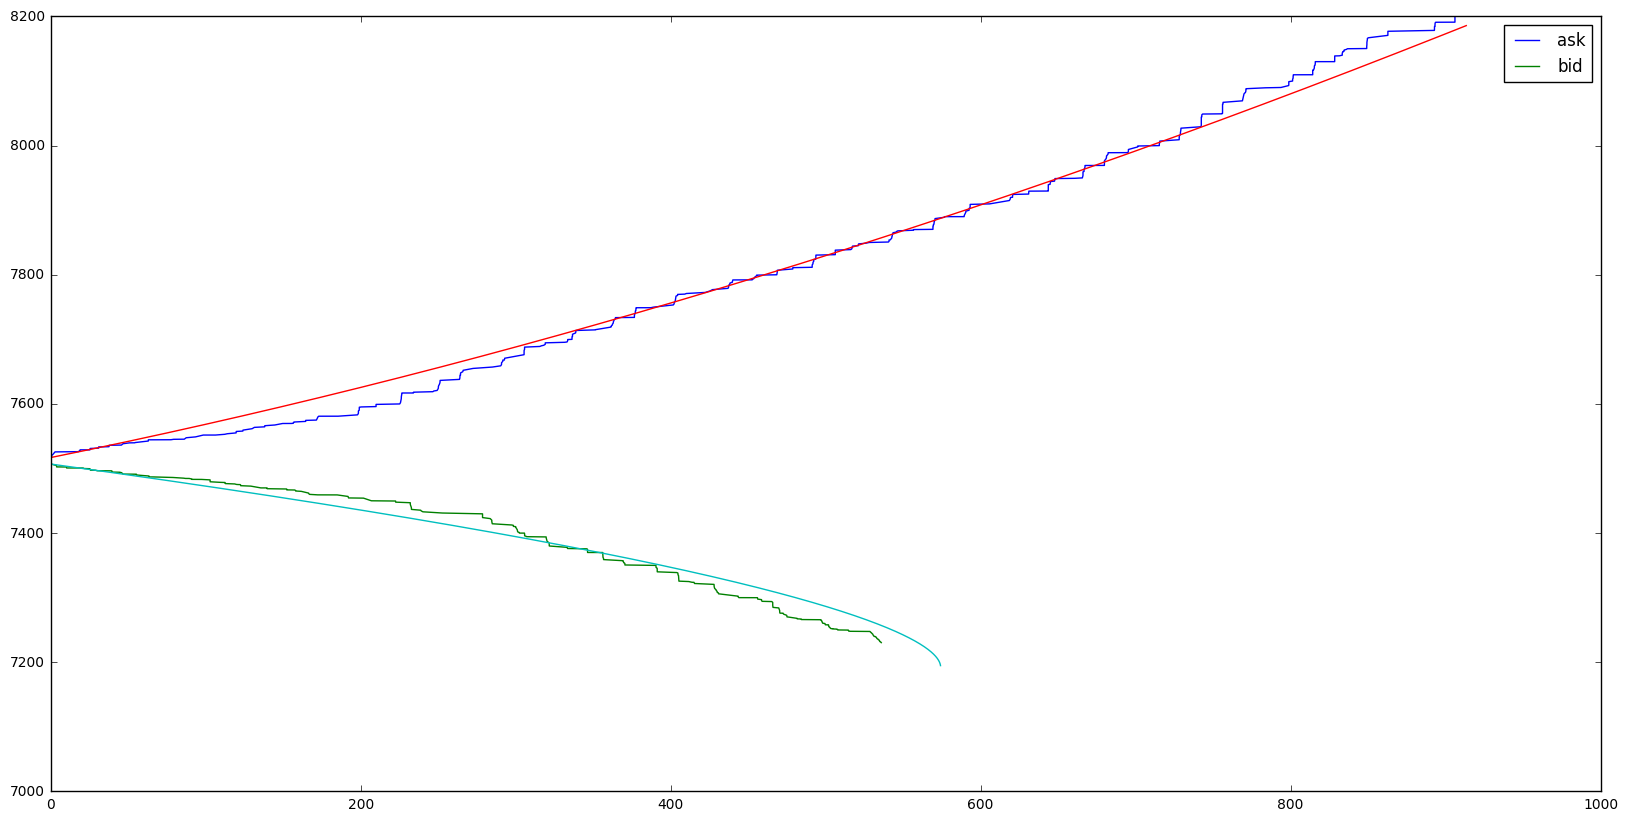

In [143]:
plt.figure(figsize=(20,10))


N = 500

plt.plot(yaskamount[:N], yask0+yaskprice[:N], label='ask')
plt.plot(ybidamount[:N], ybid0+ybidprice[:N], label='bid')

xdata = np.linspace(0,N,N)

plt.plot(amount(xdata, *argsaskamount), yask0+price(xdata, *argsaskprice))
plt.plot(amount(xdata, *argsbidamount), ybid0+price(xdata, *argsbidprice))
plt.legend()
plt.show()

In [144]:
r = Reader('bitstamp')
x = r.get(r.dates[-10:], 1000)

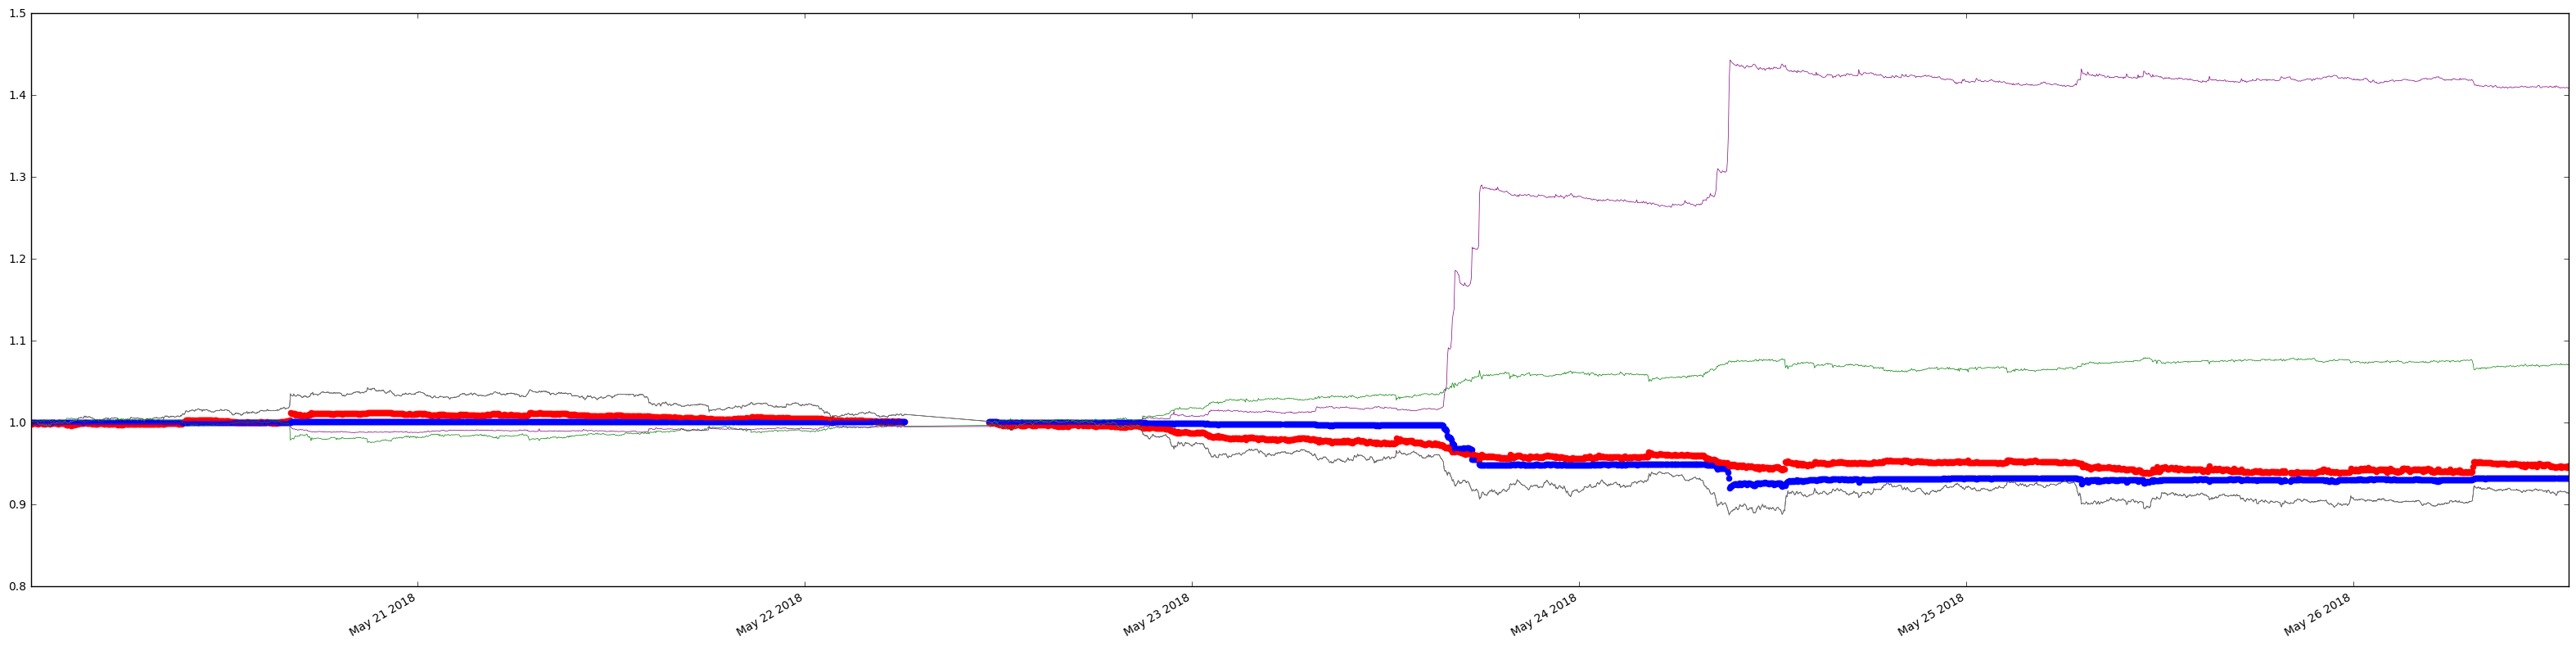

In [145]:
fig, ax = plt.subplots(figsize=(40,10))
fig.autofmt_xdate()
ax.set_xlim([x[0]['epoch'], x[-1]['epoch']])

X = x.size
for i in range(X):
    vx = x[i]['epoch']
    plt.scatter(x=vx, y=x[i]['orderbook']['ask']['price'][-1]/x[0]['orderbook']['ask']['price'][-1], color='red')
    plt.scatter(x=vx, y=x[i]['orderbook']['bid']['price'][-1]/x[0]['orderbook']['bid']['price'][-1], color='blue')
plt.plot(x['epoch'], x['bid']['price']/x['bid']['price'][0], color='black', lw=0.5)
plt.plot(x['epoch'], x['ask']['price']/x['ask']['price'][0], color='grey', lw=0.5)
plt.plot(x['epoch'], x['ask']['qtd']/x['ask']['qtd'][0], color='green', lw=0.5)
plt.plot(x['epoch'], x['bid']['qtd'][0]/x['bid']['qtd'], color='purple', lw=0.5)
plt.show()   

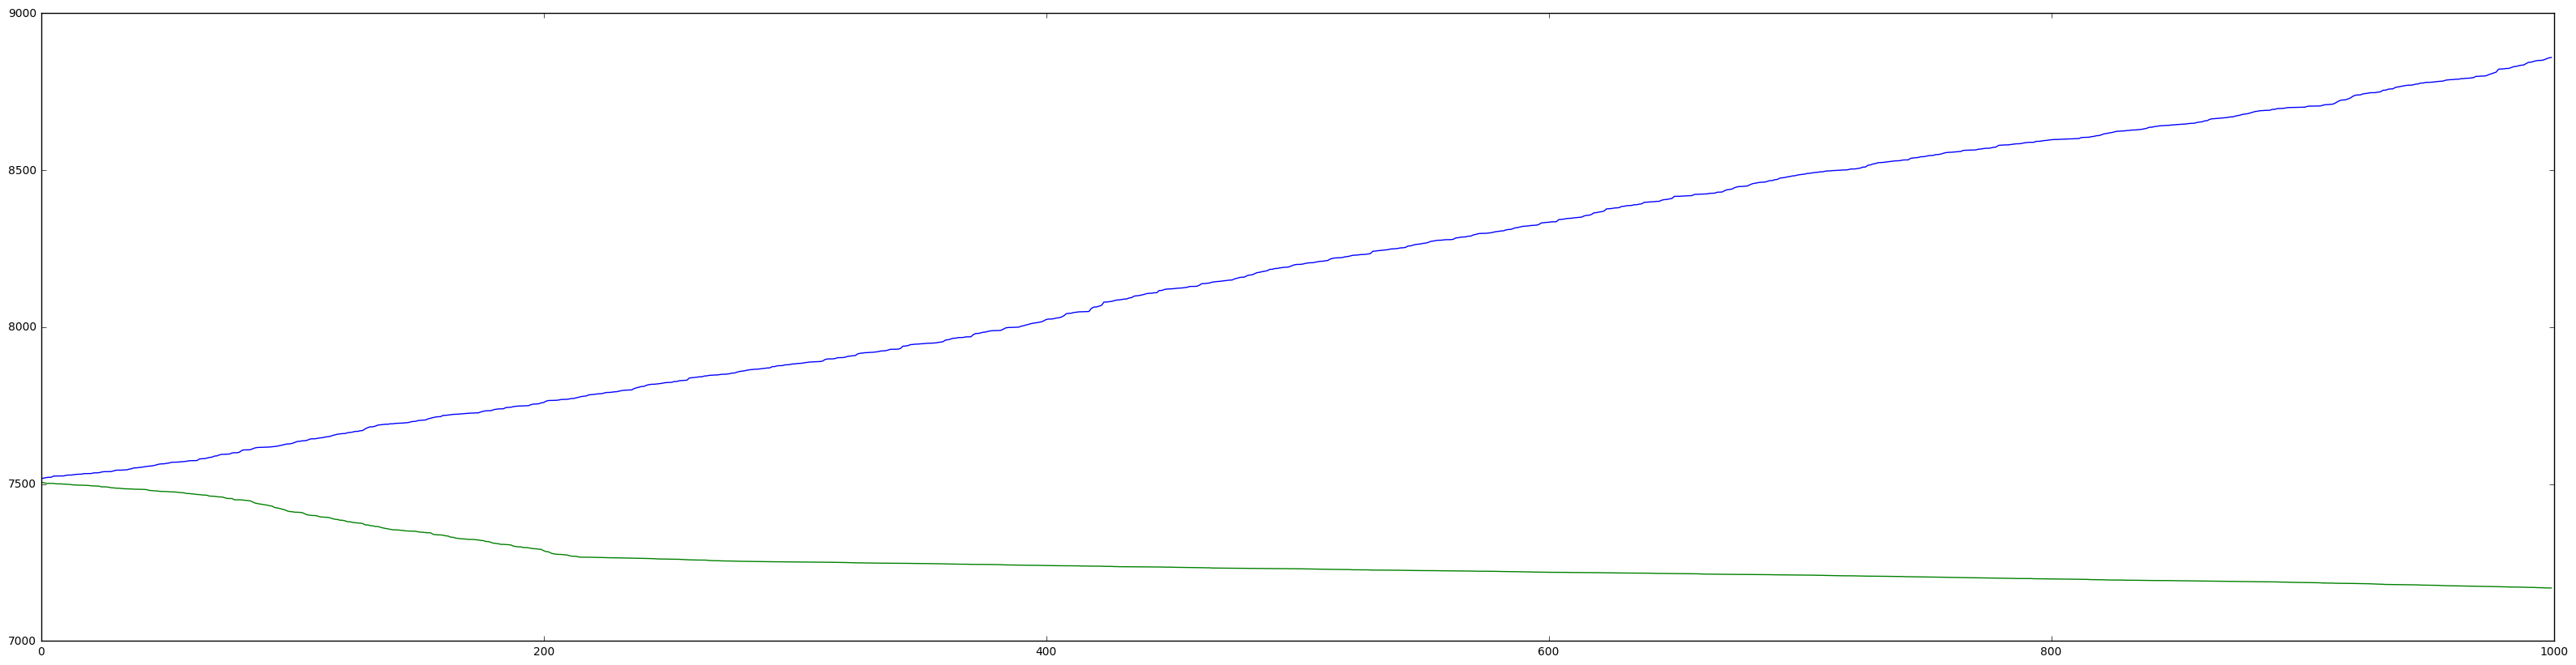

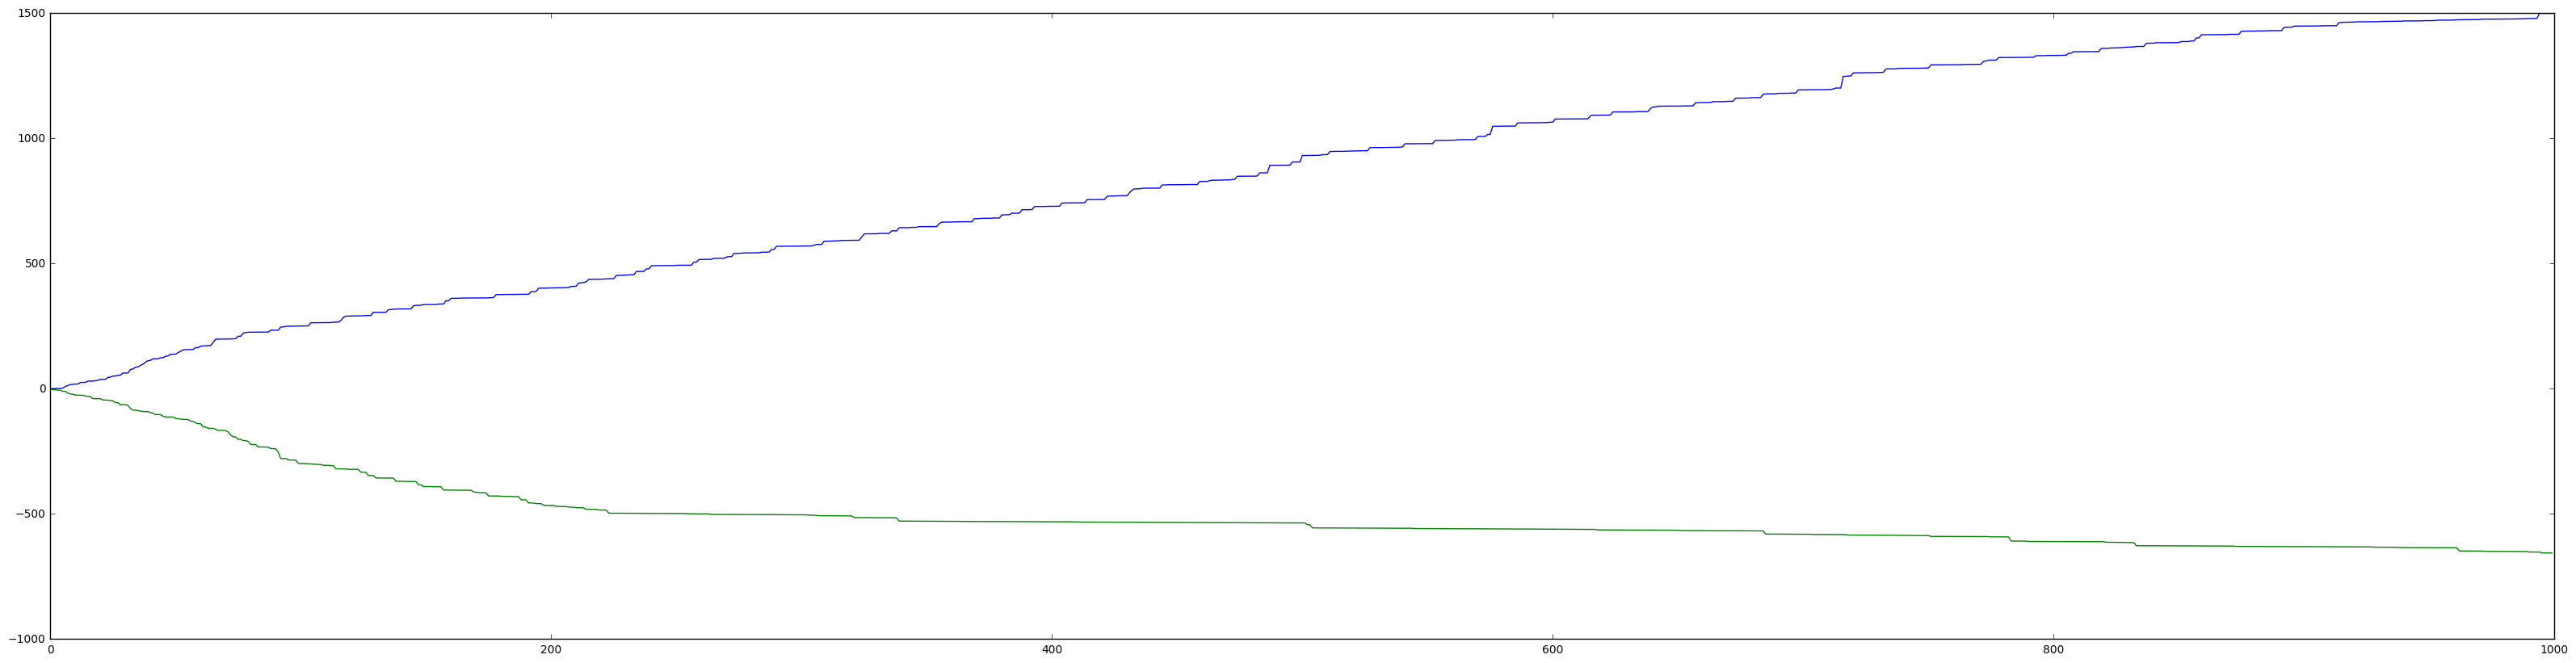

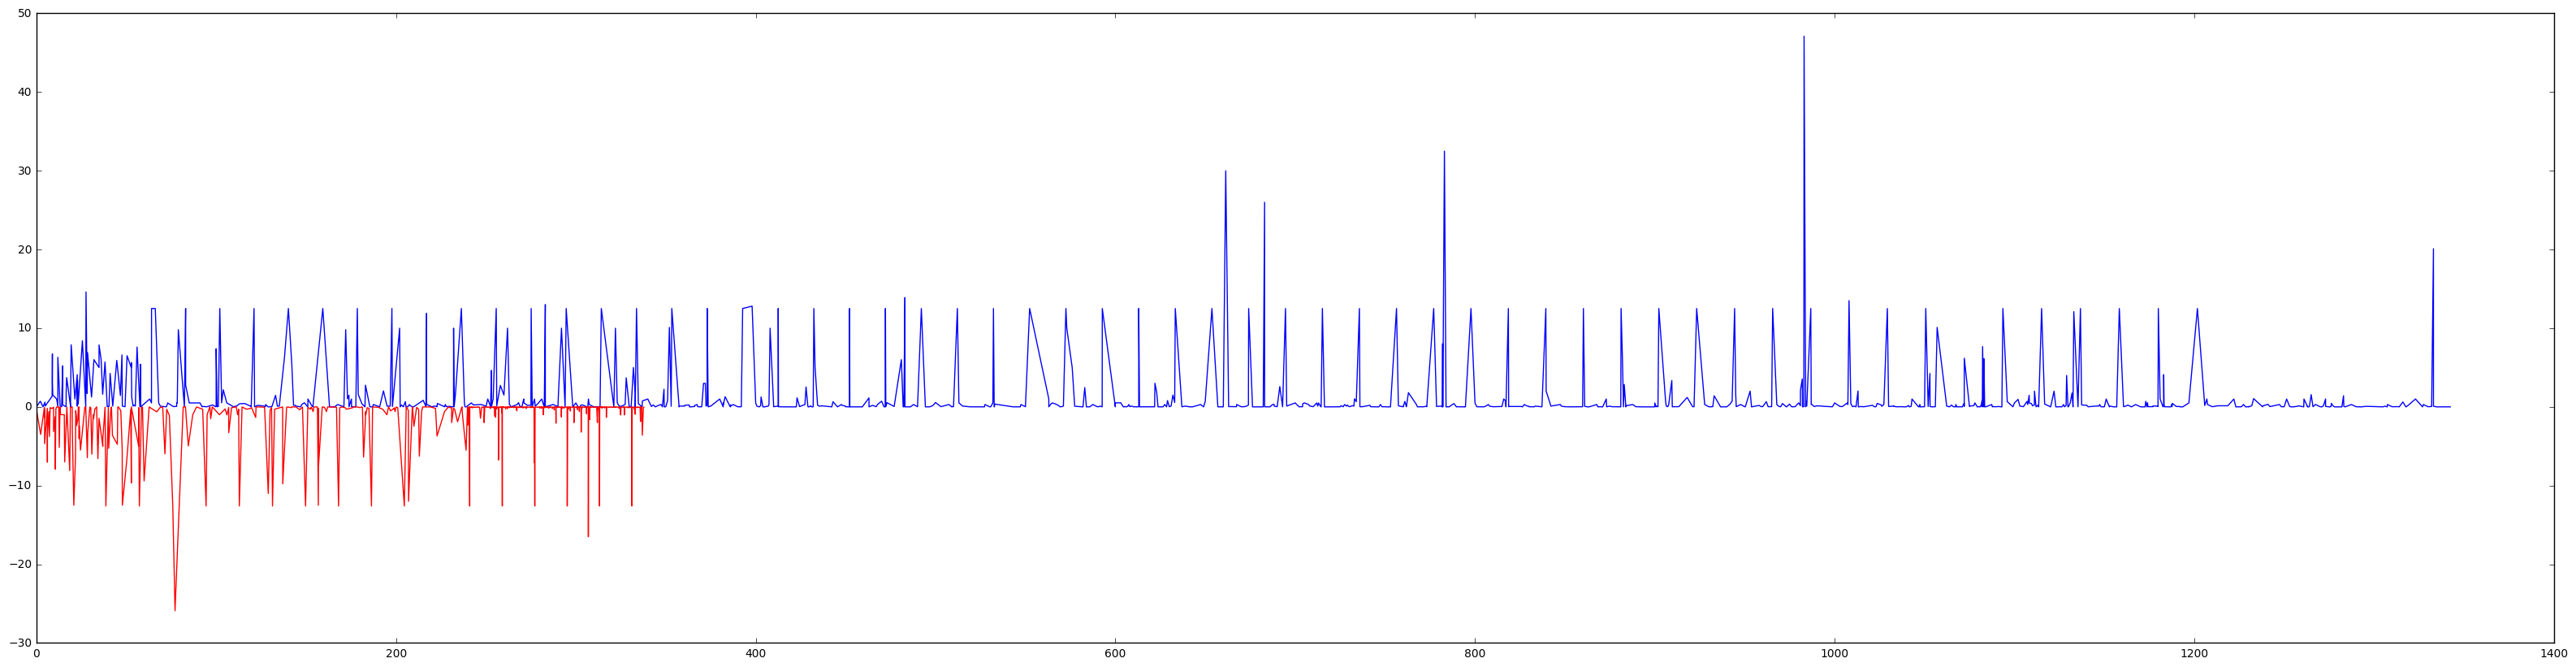

In [146]:
fig, ax = plt.subplots(figsize=(40,10))
plt.plot(x[-1]['orderbook']['ask']['price'])
plt.plot(x[-1]['orderbook']['bid']['price'])
fig, ax = plt.subplots(figsize=(40,10))
plt.plot(x[-1]['orderbook']['ask']['amount'].cumsum())
plt.plot(-x[-1]['orderbook']['bid']['amount'].cumsum())

fig, ax = plt.subplots(figsize=(40,10))
ask0 = x[-1]['orderbook']['ask']['price'][0]
bid0 = x[-1]['orderbook']['bid']['price'][0]
plt.plot(x[-1]['orderbook']['ask']['price']-ask0, x[-1]['orderbook']['ask']['amount'], color='blue')
plt.plot(bid0-x[-1]['orderbook']['bid']['price'], -x[-1]['orderbook']['bid']['amount'], color='red')